# Libs Import


In [1]:
# %load_ext autoreload
# %autoreload 2
from typing import Optional, Tuple, Literal

import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import jax.random as jrandom 
import jax.nn as jnn
import equinox as eqx
import optax
from tqdm.notebook import tqdm
from collections import defaultdict
from functools import partial
from scipy.stats import spearmanr, pearsonr

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platforms', 'cpu')

# jax.config.update('jax_check_tracer_leaks', True) 
sys.path.append("../../..")
from lib.ml.icnn_modules import ProbStackedICNNImputer, ImputerMetrics, ProbICNNImputerTrainer
import lib.ehr.example_datasets.mimiciv_aki as m4aki
from lib.ehr.tvx_ehr import TVxEHR
from lib.utils import modified_environ, write_config, append_params_to_zip, zip_members
 

In [2]:
?pub_ready_plots.get_mpl_rcParams

Object `pub_ready_plots.get_mpl_rcParams` not found.


In [3]:
import pub_ready_plots
from pub_ready_plots import get_mpl_rcParams
rc_params, fig_width_in, fig_height_in = pub_ready_plots.get_mpl_rcParams(
    width_frac=1,  # between 0 and 1
    height_frac=0.2,  # between 0 and 1
    layout="jmlr"  # or "iclr", "neurips", "poster-portrait", "poster-landscape"
)
rc_params['figure.constrained_layout.use'] = True

# rc_params['font.size'] = 10
# rc_params['axes.titlesize'] = 12
# rc_params['axes.labelsize'] = 10
# rc_params['legend.fontsize'] = 10

plt.rcParams.update(rc_params)


# Experiment Defnitions

In [4]:
EXP_DIR = 'experiment_snapshots_mimic_ProbStackedICNN_lognormal'
# model = ProbStackedICNNImputer(observables_size=obs_mask.shape[1],
#                                state_size = 0,
#                                optax_optimiser_name='polyak_sgd',
#                                hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))
# trainer = ProbICNNImputerTrainer(loss='log_normal')

# Data Loading

## First Time Loading and Writing to Disk

In [10]:
# tvx = m4aki.TVxAKIMIMICIVDataset.load('/home/asem/GP/ehr-data/mimic4aki-cohort/tvx_aki.h5')

In [11]:
# obs = [adm.observables  for subject in tvx0.subjects.values() for adm in subject.admissions]
# adm_id = sum(([adm.admission_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])
# subj_id = sum(([subject.subject_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])

In [12]:
# obs_val = np.vstack([obs_i.value for obs_i in obs])
# obs_mask = np.vstack([obs_i.mask for obs_i in obs])
# obs_time = np.hstack([obs_i.time for obs_i in obs])

In [13]:
# tvx0.scheme.obs
# features = list(map(tvx0.scheme.obs.desc.get, tvx0.scheme.obs.codes))

In [14]:
# obs_val = pd.DataFrame(obs_val, columns=features)
# obs_mask = pd.DataFrame(obs_mask.astype(int), columns=features)
# meta = pd.DataFrame({'subject_id': subj_id, 'admission_id': adm_id, 'time': obs_time})


In [15]:
# artificial_mask = obs_mask.copy()
# artificial_mask = obs_mask & np.array(jrandom.bernoulli(jrandom.PRNGKey(0), p=0.8, shape=obs_mask.shape))


In [16]:
# obs_val.to_csv('missingness_data/missingness_vals.csv')
# obs_mask.to_csv('missingness_data/missingness_mask.csv')
# meta.to_csv('missingness_data/meta.csv')
# artificial_mask.to_csv('missingness_data/missingness_artificial_mask.csv')


## Later Loading from Disk

In [5]:
obs_val = pd.read_csv('missingness_data/missingness_vals.csv', index_col=[0])
obs_mask = pd.read_csv('missingness_data/missingness_mask.csv', index_col=[0])
artificial_mask = pd.read_csv('missingness_data/missingness_artificial_mask.csv', index_col=[0])
meta = pd.read_csv('missingness_data/meta.csv', index_col=[0])


## Split

In [6]:
split_ratio = 0.7
seed = 0
indices = jrandom.permutation(jrandom.PRNGKey(seed), len(obs_val))
train_idx = indices[:int(split_ratio * len(indices))]
test_idx = indices[int(split_ratio * len(indices)):]

obs_val_train = jnp.array(obs_val.iloc[train_idx].to_numpy())
obs_mask_train = jnp.array(obs_mask.iloc[train_idx].to_numpy())
art_mask_train =  jnp.array(artificial_mask.iloc[train_idx].to_numpy())

obs_val_test = jnp.array(obs_val.iloc[test_idx].to_numpy())
obs_mask_test = jnp.array(obs_mask.iloc[test_idx].to_numpy())
art_mask_test =  jnp.array(artificial_mask.iloc[test_idx].to_numpy())

# Model Configuration

In [7]:
# model = ICNNObsDecoder(observables_size=obs_mask.shape[1], state_size=0, 
#                        optax_optimiser_name='polyak_sgd',
#                        hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))

model = ProbStackedICNNImputer(observables_size=obs_mask.shape[1],
                               state_size = 0,
                               optax_optimiser_name='polyak_sgd',
                               hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))
trainer = ProbICNNImputerTrainer(loss='log_normal')

# Training

## ICNN Training

In [12]:
lr=1e-3
steps=10000
train_batch_size=256
test_batch_size=1024
# train_batch_size=1
# test_batch_size=1
eval_frequency = 10
model_snapshot_frequency = 100

optim = optax.novograd(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
data_train = (obs_val_train, obs_mask_train, art_mask_train)
data_test = (obs_val_test, obs_mask_test, art_mask_test)

In [13]:
train_batches = trainer.dataloader(data_train, train_batch_size, key=jrandom.PRNGKey(0))
test_batches = iter(trainer.dataloader(data_test, train_batch_size, key=jrandom.PRNGKey(0)))
train_history = defaultdict(list)
test_history = defaultdict(list)
model_snapshots = {}

In [14]:
progress = tqdm(range(steps))

for step, batch_train in zip(progress, train_batches):
    start = time.time()
    (train_loss, train_aux), model, opt_state = trainer.make_step(model, optim, opt_state, *batch_train)
    r2_vec =  trainer.model_r_squared(model, *batch_train)
    r2_vec_rank = trainer.model_r_squared_ranked_prob(model, *batch_train, k=5)
    r2_vec = np.array(r2_vec)
    train_nsteps = int(sum(train_aux.n_steps) / len(train_aux.n_steps))
    train_history['R2'].append(r2_vec)
    train_history['R2_rank5'].append(r2_vec_rank)
    train_history['loss'].append(train_loss)
    train_history['n_opt_steps'].append(train_nsteps)
    
    end = time.time()
    if (step % eval_frequency) == 0 or step == steps - 1:
        batch_test = next(test_batches)
        test_loss, _ = trainer.loss(model, *batch_test)
        r2_vec_test = trainer.model_r_squared(model, *batch_test)
        r2_vec_rank_test = trainer.model_r_squared_ranked_prob(model, *batch_test, k=10)
        r2_vec_test = np.array(r2_vec_test)
        test_history['loss'].append(test_loss)
        test_history['R2'].append(r2_vec_test)
        test_history['R2_rank10'].append(r2_vec_rank_test)

    if (step % model_snapshot_frequency) == 0 or step == steps - 1:
        model_snapshots[step] = model
        append_params_to_zip(model, f'step{step:04d}.eqx', f'{EXP_DIR}/params.zip')

    progress.set_description(f"Trn-L: {train_loss:.3f}, Trn-R2: ({np.nanmax(r2_vec_rank):.2f}, {np.nanmin(r2_vec_rank):.2f}, {np.nanmean(r2_vec_rank):.2f}, {np.nanmedian(r2_vec_rank):.2f}),  Trn-N-steps: {train_nsteps}, " 
                             f"Tst-L:  {test_loss:.3f}, Tst-R2:  ({np.nanmax(r2_vec_rank_test):.2f}, {np.nanmin(r2_vec_rank_test):.2f}, {np.nanmean(r2_vec_rank_test):.2f}, {np.nanmedian(r2_vec_rank_test):.2f}), "
                             f"Computation time: {end - start:.2f}, ")
                            

In [300]:
# zip_members(f'{EXP_DIR}/params.zip')

### Dump Training Statistics

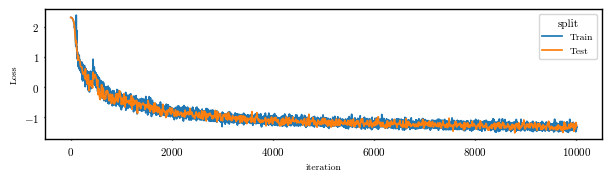

In [8]:
# FIRST TIME - BEGIN 

# train_stats = pd.DataFrame(train_history)
# test_stats = pd.DataFrame(test_history)

# train_stats['split'] = 'Train'
# train_stats['iteration'] = train_stats.index + 1
# test_stats['split'] = 'Test'
# test_stats['iteration'] = (test_stats.index * eval_frequency) + 1
# training_stats = pd.concat([train_stats, test_stats])
# training_stats_melted = pd.melt(training_stats, value_vars=['loss'], id_vars=['split', 'iteration'], value_name='Loss')
# training_stats_melted = training_stats_melted.astype({'Loss': float})

# training_stats.to_csv(f'{EXP_DIR}/icnn_training_stats.csv')  
# training_stats_melted.to_csv(f'{EXP_DIR}/icnn_training_stats_melted.csv')  

# FIRST TIME - END 


# LATER TIMES
training_stats = pd.read_csv(f'{EXP_DIR}/icnn_training_stats.csv', index_col=[0])  
training_stats_melted = pd.read_csv(f'{EXP_DIR}/icnn_training_stats_melted.csv', index_col=[0])  



g2 = sns.lineplot(data=training_stats_melted, x="iteration", y="Loss", hue="split")
g2.get_figure().set_size_inches(fig_width_in, fig_height_in)
g2.get_figure().savefig("training_stats.pdf")

## Sklearn Training

In [9]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

sklearn_imputers =  {
    'zero_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="constant", fill_value=0),
    'mean_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="mean", fill_value=0),
    'knn_imputer': lambda: KNNImputer(missing_values=np.nan),
    'iter_imputer': lambda: IterativeImputer(
        missing_values=np.nan,
        add_indicator=False,
        random_state=0,
        n_nearest_features=5,
        max_iter=5,
        sample_posterior=True,
    )
}

sklearn_trained_imputers = {k: v().fit(np.where(obs_mask_train, obs_val_train, np.nan)) for k, v in sklearn_imputers.items()} 

# Metrics / Results

In [10]:
prediction_mask = (1 - art_mask_test) * obs_mask_test
feature2index =  dict(zip(obs_val.columns, range(len(obs_val.columns))))
n_train = ((1 - art_mask_train) * obs_mask_train).sum(axis=0)
n_test = ((1 - art_mask_test) * obs_mask_test).sum(axis=0)
n_train_measured = obs_mask_train.sum(axis=0)
missingness = 1 - obs_mask.mean(axis=0)
validation_missingness = 1 - pd.DataFrame(art_mask_test, columns=obs_mask.columns).mean(axis=0)

In [11]:
variable_map = {'blood_chemistry.albumin': 'Albumin',  'blood_chemistry.aniongap': 'Aniongap',  'blood_chemistry.bicarbonate': 'Bicarbonate',  'blood_chemistry.bun': 'Urea Nitrogen',  'blood_chemistry.calcium': 'Calcium',  'blood_chemistry.chloride': 'Chloride',  'blood_chemistry.creatinine': 'Creatinine',  'blood_chemistry.globulin': 'Globulin',  'blood_chemistry.glucose': 'Glucose',  'blood_chemistry.potassium': 'Potassium',  'blood_chemistry.sodium': 'Sodium',  'blood_chemistry.total_protein': 'Protein Total',  'blood_diff.atypical_lymphocytes': 'Atypical Lymphocytes',  'blood_diff.bands': 'Bands (%)',  'blood_diff.basophils': 'Basophils',  'blood_diff.basophils_abs': 'Abs Basophils',  'blood_diff.eosinophils': 'Eosinophils',  'blood_diff.eosinophils_abs': 'Abs Eosinophils',  'blood_diff.immature_granulocytes': 'Immature Granulocytes',  'blood_diff.lymphocytes': 'Lymphocytes',  'blood_diff.lymphocytes_abs': 'Abs Lymphocytes',  'blood_diff.metamyelocytes': 'Metamyelocytes',  'blood_diff.monocytes': 'Monocytes',  'blood_diff.monocytes_abs': 'Abs Monocytes',  'blood_diff.neutrophils': 'Neutrophils',  'blood_diff.neutrophils_abs': 'Abs Neutrophil',  'blood_diff.nrbc': 'NRBC',  'blood_gas.aado2': 'AaDO2',  'blood_gas.aado2_calc': 'AaDO2_calc',  'blood_gas.baseexcess': 'Base excess',  'blood_gas.bicarbonate': 'Bicarbonate',  'blood_gas.calcium': 'Calcium',  'blood_gas.carboxyhemoglobin': 'Carboxyhemoglobin',  'blood_gas.chloride': 'Chloride',  'blood_gas.fio2': 'FiO2',  'blood_gas.fio2_chartevents': 'FiO2_chartevents',  'blood_gas.glucose': 'Glucose',  'blood_gas.hematocrit': 'Hematocrit',  'blood_gas.hemoglobin': 'Hemoglobin',  'blood_gas.lactate': 'Lactate',  'blood_gas.methemoglobin': 'Methemoglobin',  'blood_gas.pao2fio2ratio': 'pO2/FiO2 ratio',  'blood_gas.pco2': 'pCO2',  'blood_gas.ph': 'pH',  'blood_gas.po2': 'pO2',  'blood_gas.potassium': 'Potassium',  'blood_gas.so2': 'sO2',  'blood_gas.sodium': 'Sodium',  'blood_gas.temperature': 'Temperature',  'blood_gas.totalco2': 'CO2 total',  'cardiac_marker.ck_mb': 'Creatinine Kinase, MB',  'cardiac_marker.ntprobnp': 'NT-proBNP',  'cardiac_marker.troponin_t2': 'Troponin T',  'cbc.hematocrit': 'Hematocrit',  'cbc.hemoglobin': 'Hemoglobin',  'cbc.mch': 'MCH',  'cbc.mchc': 'MCHC',  'cbc.mcv': 'MCV',  'cbc.platelet': 'Platelet',  'cbc.rbc': 'RBC',  'cbc.rdw': 'RDW',  'cbc.wbc': 'WBC',  'coagulation.d_dimer': 'D-Dimer',  'coagulation.fibrinogen': 'Fibrinogen',  'coagulation.inr': 'INR',  'coagulation.pt': 'PT',  'coagulation.ptt': 'PTT',  'coagulation.thrombin': 'Thrombin',  'enzymes.alp': 'ALP',  'enzymes.alt': 'ALT',  'enzymes.amylase': 'Amylase',  'enzymes.ast': 'AST',  'enzymes.bilirubin_direct': 'Bilirubin direct',  'enzymes.bilirubin_indirect': 'Bilirubin indirect',  'enzymes.bilirubin_total': 'Bilirubin total',  'enzymes.ck_cpk': 'CK-CPK',  'enzymes.ck_mb':'CK-MB',  'enzymes.ggt': 'GGT',  'enzymes.ld_ldh': 'ld_ldh',  'icp.icp': 'Intra-cranial Press.',  'inflammation.crp': 'CRP',  'renal_aki.aki_binary': 'AKI (binary)',  'renal_aki.aki_stage_smoothed': 'AKI',  'renal_creat.creat': 'Creatinine',  'renal_out.uo_rt_12hr': 'Urine out 12h',  'renal_out.uo_rt_24hr': 'Urine out 24h',  'renal_out.uo_rt_6hr': 'Urine out 6h',  'sofa.sofa_24hours': 'SOFA',  'vital.dbp': 'Diastolic BP',  'vital.dbp_ni': 'NI-Diastolic BP',  'vital.glucose': 'Glucose',  'vital.heart_rate': 'Heart Rate',  'vital.mbp':  'Mean BP',  'vital.mbp_ni': 'NI Mean BP',  'vital.resp_rate': 'Respiratory Rate',  'vital.sbp': 'Systolic BP',  'vital.sbp_ni':  'NI-Systolic BP',  'vital.spo2': 'SpO2',  'vital.temperature': 'Temperature',  'weight.weight': 'Weight'}

## Metrics Evolution with ICNN Training

In [ ]:
# FIRST TIME - BEGIN 

# dataframes = []
# for step, model_snap in tqdm(model_snapshots.items()):
#     with jax.default_device(jax.devices("cpu")[0]):
#         obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
#         (X_test_imp, X_test_std), _ = eqx.filter_vmap(model_snap.prob_partial_input_optimise)(obs_test, art_mask_test)
    
#     sigma_threshold = [4.0, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
#     r2_vec_thresholded = [eqx.filter_vmap(ProbICNNImputerTrainer.r_squared_thresholded_prob)(obs_val_test.T, X_test_imp.T, prediction_mask.T, X_test_std.T,  t)
#                           for t in sigma_threshold]
    
#     r2_test_results = pd.DataFrame(np.vstack(r2_vec_thresholded), columns=obs_val.columns)
#     r2_test_results['sigma_threshold'] = sigma_threshold
#     r2_test_results['step'] = step
#     dataframes.append(r2_test_results)

# r2_iters_test_results = pd.concat(dataframes)
# r2_iters_test_results = pd.melt(r2_iters_test_results, value_vars=list(obs_val.columns), id_vars=['sigma_threshold', 'step'], value_name='R2')

# r2_iters_test_results.to_csv(f'{EXP_DIR}/r2_iters_test_results.csv')
# FIRST TIME - END 
r2_iters_test_results = pd.read_csv(f'{EXP_DIR}/r2_iters_test_results.csv', index_col=[0])

In [57]:
# r2_iters_test_results

## Metrics of the Last ICNN Snapshot

In [12]:
model = model.load_params_from_archive(f'{EXP_DIR}/params.zip', 'step9999.eqx')

In [13]:
# FIRST TIME - BEGIN 
# with jax.default_device(jax.devices("cpu")[0]):
#     obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
#     (X_test_imp, X_test_std), _ = eqx.filter_vmap(model.prob_partial_input_optimise)(obs_test, art_mask_test)

# X_test_imp_df = pd.DataFrame(X_test_imp, columns=obs_val.columns)
# X_test_std_df = pd.DataFrame(X_test_std, columns=obs_val.columns)

# X_test_imp_df.to_csv(f'{EXP_DIR}/icnn_pred_X_test_imp.csv')
# X_test_std_df.to_csv(f'{EXP_DIR}/icnn_pred_X_test_std.csv')
# FIRST TIME - END 

X_test_imp_df = pd.read_csv(f'{EXP_DIR}/icnn_pred_X_test_imp.csv', index_col=[0])
X_test_std_df = pd.read_csv(f'{EXP_DIR}/icnn_pred_X_test_std.csv', index_col=[0])
X_test_imp = X_test_imp_df.to_numpy()
X_test_std = X_test_std_df.to_numpy()


In [14]:
# FIRST TIME - BEGIN 

# icnn_X_test_se = (X_test_imp_df - np.array(obs_val_test))**2
# icnn_X_test_se = icnn_X_test_se.where(prediction_mask.astype(bool), other=np.nan)
# icnn_X_test_se = pd.melt(icnn_X_test_se, value_vars=list(obs_val.columns), value_name='SE')
# icnn_X_test_se = icnn_X_test_se[icnn_X_test_se.SE.notnull()]
# icnn_X_test_se['Imputer'] = 'ICNN'
# icnn_X_test_se.to_csv(f'{EXP_DIR}/icnn_X_test_se.csv')

# FIRST TIME - END 
icnn_X_test_se = pd.read_csv(f'{EXP_DIR}/icnn_X_test_se.csv', index_col=[0])
icnn_X_test_se

,variable,SE,Imputer
1065,blood_chemistry.albumin,0.698059,ICNN
1230,blood_chemistry.albumin,0.687116,ICNN
1484,blood_chemistry.albumin,0.000719,ICNN
1675,blood_chemistry.albumin,0.000834,ICNN
1847,blood_chemistry.albumin,0.201607,ICNN
...,...,...,...
20815337,weight.weight,0.000418,ICNN
20815638,weight.weight,0.041595,ICNN
20815715,weight.weight,0.008200,ICNN
20815748,weight.weight,0.039207,ICNN


In [15]:
# FIRST TIME - BEGIN 
# SE = (X_test_imp - obs_val_test) ** 2
# SE = jnp.where(prediction_mask, SE, jnp.nan)
# X_test_var = jnp.where(prediction_mask, X_test_std ** 2, jnp.nan)

# se_data = defaultdict(list)
# for i in range(SE.shape[1]):
#     se_data['SE'].extend(np.array(SE[:, i][prediction_mask[:, i].astype(bool)]).tolist())
#     se_data['sigma2'].extend(np.array(X_test_var[:, i][prediction_mask[:, i].astype(bool)]).tolist())
#     se_data['Feature'].extend([obs_val.columns[i]] * int(prediction_mask[:, i].sum()))
    
# se_df = pd.DataFrame(se_data)
# se_df.to_csv(f'{EXP_DIR}/icnn_se_stats.csv')
# FIRST TIME - END 

# LATER TIMES
se_df = pd.read_csv(f'{EXP_DIR}/icnn_se_stats.csv', index_col=[0])

In [16]:
# FIRST TIME - BEGIN 

# features_r2 = eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(obs_val_test.T, X_test_imp.T, prediction_mask.T)
# features_ss_total = jnp.nansum((obs_val_test - obs_val_test.mean(axis=0))**2, where=prediction_mask, axis=0)
# features_ss_res = (1 - features_r2) * features_ss_total
# features_mse = jnp.where(prediction_mask.sum(axis=0) > 2, features_ss_res / prediction_mask.sum(axis=0), jnp.nan)

# sigma_threshold = [4.0, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
# r2_vec_thresholded = [eqx.filter_vmap(ProbICNNImputerTrainer.r_squared_thresholded_prob)(obs_val_test.T, X_test_imp.T, prediction_mask.T, X_test_std.T,  t)
#                       for t in sigma_threshold]
# r2_test_thresholded_df = pd.DataFrame(np.vstack(r2_vec_thresholded), columns=obs_val.columns)
# r2_test_thresholded_df['sigma_threshold'] = sigma_threshold

# r2_test_thresholded_melted_df = pd.melt(r2_test_thresholded_df, value_vars=list(obs_val.columns), id_vars=['sigma_threshold'], value_name='R2')


# icnn_features_stats = defaultdict(list)
# n_train = ((1 - art_mask_train) * obs_mask_train).sum(axis=0)

# for feature, feature_df in se_df.groupby('Feature'):
#     icnn_features_stats['Feature'].append(feature)
#     icnn_features_stats['n_training_measured'].append(n_train_measured[feature2index[feature]])
#     icnn_features_stats['n_training_censored'].append(n_train[feature2index[feature]])
#     icnn_features_stats['n_test_censored'].append(n_test[feature2index[feature]])
#     icnn_features_stats['missingness'].append(missingness[feature2index[feature]].item())
#     icnn_features_stats['R2'].append(features_r2[feature2index[feature]].item())
#     icnn_features_stats['MSE'].append(features_mse[feature2index[feature]].item())

#     icnn_features_stats['sigma2_se_spearman'].append(spearmanr(feature_df['SE'], feature_df['sigma2']).statistic)
    
# icnn_features_stats_df = pd.DataFrame(icnn_features_stats)


# r2_test_thresholded_df.to_csv(f'{EXP_DIR}/r2_test_thresholded.csv')
# r2_test_thresholded_melted_df.to_csv(f'{EXP_DIR}/r2_test_thresholded_melted.csv')
# icnn_features_stats_df.to_csv(f'{EXP_DIR}/icnn_features_stats.csv')  

# LATER TIMES
r2_test_thresholded_df = pd.read_csv(f'{EXP_DIR}/r2_test_thresholded.csv', index_col=[0])
r2_test_thresholded_melted_df = pd.read_csv(f'{EXP_DIR}/r2_test_thresholded_melted.csv', index_col=[0])
icnn_features_stats_df = pd.read_csv(f'{EXP_DIR}/icnn_features_stats.csv', index_col=[0])


In [18]:
spearman_se_sigma_all = spearmanr(se_df['SE'], se_df['sigma2']).statistic
pearson_se_sigma_all = pearsonr(se_df['SE'], se_df['sigma2']).statistic
r2_all = ProbICNNImputerTrainer.r_squared(obs_val_test, X_test_imp, prediction_mask)
ss_total = jnp.nansum((obs_val_test - obs_val_test.mean())**2, where=prediction_mask)
ss_res = (1 - r2_all) * ss_total
mse =  ss_res / prediction_mask.sum()

icnn_global_stats = pd.DataFrame({r'$r_\text{Pearson}(SE, \sigma^2)$': [pearson_se_sigma_all],
                                  r'$r_\text{Spearman}(SE, \sigma^2)$': [spearman_se_sigma_all],
                                  r'$R^2(z, \mu)$': [r2_all],
                                  'MSE': [mse]})
icnn_global_stats.to_csv(f'{EXP_DIR}/icnn_global_stats.csv')  
icnn_global_stats

,"$r_\text{Pearson}(SE, \sigma^2)$","$r_\text{Spearman}(SE, \sigma^2)$","$R^2(z, \mu)$",MSE
0,0.486482,0.528621,0.08888369498337212,0.1610370886714436


In [19]:
icnn_features_stats_df.sort_values('R2').tail(15)

,Feature,n_training_measured,n_training_censored,n_test_censored,missingness,R2,MSE,sigma2_se_spearman
94,vital.resp_rate,256055,51434,21899,0.472667,-0.029139,0.067043,-0.007356
29,blood_gas.baseexcess,16320,3208,1395,0.966564,-0.028819,1.083601,-0.106153
28,blood_gas.aado2_calc,10615,2138,894,0.978184,-0.015484,0.940689,0.013050
88,vital.dbp,250547,49912,21812,0.484286,0.086894,0.048170,-0.042985
86,renal_out.uo_rt_6hr,118692,24094,10207,0.755558,0.094348,0.847144,0.025233
87,sofa.sofa_24hours,234811,46864,20097,0.516244,0.117081,0.077328,0.067016
85,renal_out.uo_rt_24hr,93648,18884,8003,0.807002,0.127068,0.816370,0.015663
84,renal_out.uo_rt_12hr,111206,22319,9479,0.770966,0.132485,0.820214,0.001454
96,vital.sbp_ni,160742,32288,13670,0.669441,0.140980,0.055608,-0.009288
89,vital.dbp_ni,159826,32044,13658,0.671344,0.153323,0.073005,-0.035513


In [20]:
r_classes = [r'$r > 0.3$', r'$r \in (0.1, 0.3]$', r'$r \in (-0.1, 0.1]$', r'$r \leq -0.1$']
R_classes = [r'$R^2 > 0.25$', r'$R^2 \in (0.1, 0.25]$', r'$R^2 \in (-0.1, 0.1]$', r'$R^2 \leq -0.1$']
def classify_r(r):
    if r > 0.3:
        return r_classes[0]
    elif r > 0.1:
        return r_classes[1]
    elif r > -0.1:
        return r_classes[2]
    else:
        return r_classes[3]

def classify_R(R):
    if R > 0.25:
        return R_classes[0]
    elif R > 0.1:
        return R_classes[1]
    elif R > -0.1:
        return R_classes[2]
    else:
        return R_classes[3] 

icnn_features_stats_df[r'$r(\sigma^2, SE)$'] = icnn_features_stats_df.sigma2_se_spearman.map(classify_r)

vars_n300 = icnn_features_stats_df[icnn_features_stats_df.n_test_censored >= 300].Feature
print(len(vars_n300))
icnn_features_stats_df[icnn_features_stats_df.Feature.isin(vars_n300)].sort_values('sigma2_se_spearman').head(30)


73


,Feature,n_training_measured,n_training_censored,n_test_censored,missingness,R2,MSE,sigma2_se_spearman,"$r(\sigma^2, SE)$"
29,blood_gas.baseexcess,16320,3208,1395,0.966564,-0.028819,1.083601,-0.106153,$r \leq -0.1$
31,blood_gas.calcium,8120,1648,672,0.983433,-17.713607,0.226280,-0.097828,"$r \in (-0.1, 0.1]$"
0,blood_chemistry.albumin,7103,1405,612,0.985440,-18.791556,2.701496,-0.095714,"$r \in (-0.1, 0.1]$"
36,blood_gas.glucose,5853,1224,485,0.988148,-9.103304,1.719544,-0.073565,"$r \in (-0.1, 0.1]$"
74,enzymes.bilirubin_total,13393,2716,1105,0.972533,-2.471742,0.121282,-0.070201,"$r \in (-0.1, 0.1]$"
98,vital.temperature,68493,13436,5919,0.858821,-7.365018,0.009717,-0.068777,"$r \in (-0.1, 0.1]$"
81,renal_aki.aki_binary,67557,13535,5829,0.861057,-0.133421,0.100657,-0.055396,"$r \in (-0.1, 0.1]$"
95,vital.sbp,251900,50184,21660,0.481493,0.167349,0.034639,-0.045933,"$r \in (-0.1, 0.1]$"
88,vital.dbp,250547,49912,21812,0.484286,0.086894,0.048170,-0.042985,"$r \in (-0.1, 0.1]$"
89,vital.dbp_ni,159826,32044,13658,0.671344,0.153323,0.073005,-0.035513,"$r \in (-0.1, 0.1]$"


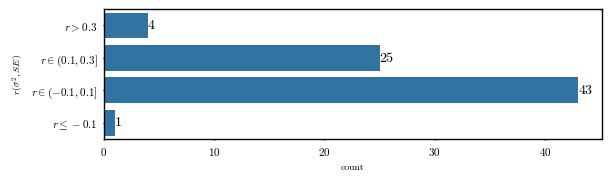

In [23]:
ax = sns.countplot(icnn_features_stats_df[icnn_features_stats_df.Feature.isin(vars_n300)], y=r'$r(\sigma^2, SE)$', order=r_classes)
ax.bar_label(ax.containers[0], fontsize=10);
ax.get_figure().set_size_inches(fig_width_in, fig_height_in)
ax.get_figure().savefig("icnn_r_sigma_SE.pdf")

## Metrics of Sklearn Models

In [24]:
# FIRST TIME - BEGIN 

# sklearn_imputed_X = {k: v.transform(np.where(art_mask_test, obs_val_test, np.nan)) for k, v in sklearn_trained_imputers.items()} 

# FIRST TIME - END 

sklearn_imputed_X = {k: v.transform(np.where(art_mask_test, obs_val_test, np.nan)) for k, v in sklearn_trained_imputers.items()
                    if k != 'knn_imputer'} 


In [25]:
# FIRST TIME - BEGIN 

sklearn_X_test_se = {k: (X_imp_ - np.array(obs_val_test))**2 for k, X_imp_ in sklearn_imputed_X.items()}
sklearn_X_test_se = {k: np.where(prediction_mask.astype(bool), X_test_se, np.nan) for k, X_test_se in sklearn_X_test_se.items()}
sklearn_X_test_se_df = []
for k, X_test_se in sklearn_X_test_se.items():
    X_test_se = pd.DataFrame(X_test_se, columns=obs_val.columns)
    df = pd.melt(X_test_se, value_vars=list(obs_val.columns), value_name='SE')
    df = df[df.SE.notnull()]
    df['Imputer'] = k
    sklearn_X_test_se_df.append(df)

sklearn_X_test_se_df = pd.concat(sklearn_X_test_se_df)
sklearn_X_test_se_df.to_csv(f'{EXP_DIR}/sklearn_X_test_se.csv')
# FIRST TIME - END 
sklearn_X_test_se_df = pd.read_csv(f'{EXP_DIR}/sklearn_X_test_se.csv', index_col=[0])
sklearn_X_test_se_df

,variable,SE,Imputer
1065,blood_chemistry.albumin,0.081567,zero_imputer
1230,blood_chemistry.albumin,0.150311,zero_imputer
1484,blood_chemistry.albumin,0.050400,zero_imputer
1675,blood_chemistry.albumin,0.201601,zero_imputer
1847,blood_chemistry.albumin,0.050400,zero_imputer
...,...,...,...
20815337,weight.weight,0.015889,iter_imputer
20815638,weight.weight,0.091407,iter_imputer
20815715,weight.weight,0.088486,iter_imputer
20815748,weight.weight,0.004486,iter_imputer


In [26]:
X_test_se_df = pd.concat([icnn_X_test_se, sklearn_X_test_se_df])
X_test_se_df['group'] = X_test_se_df.variable.str.split('.').map(lambda x: x[0])
X_test_se_df['Feature'] = X_test_se_df.variable.map(variable_map)

In [27]:
groups = X_test_se_df['group'].unique().tolist()
groups

['blood_chemistry',
 'blood_diff',
 'blood_gas',
 'cardiac_marker',
 'cbc',
 'coagulation',
 'enzymes',
 'icp',
 'inflammation',
 'renal_aki',
 'renal_creat',
 'renal_out',
 'sofa',
 'vital',
 'weight']

In [28]:
X_test_se_df

,variable,SE,Imputer,group,Feature
1065,blood_chemistry.albumin,0.698059,ICNN,blood_chemistry,Albumin
1230,blood_chemistry.albumin,0.687116,ICNN,blood_chemistry,Albumin
1484,blood_chemistry.albumin,0.000719,ICNN,blood_chemistry,Albumin
1675,blood_chemistry.albumin,0.000834,ICNN,blood_chemistry,Albumin
1847,blood_chemistry.albumin,0.201607,ICNN,blood_chemistry,Albumin
...,...,...,...,...,...
20815337,weight.weight,0.015889,iter_imputer,weight,Weight
20815638,weight.weight,0.091407,iter_imputer,weight,Weight
20815715,weight.weight,0.088486,iter_imputer,weight,Weight
20815748,weight.weight,0.004486,iter_imputer,weight,Weight


/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


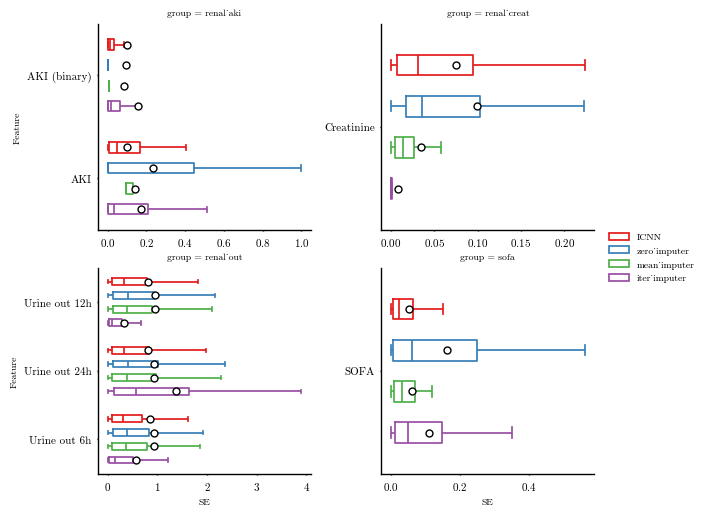

In [34]:
# enzymes (except Amylase, Bilirubin indirect, CK-CPK)
# renal_creat
# renal_aki
# renal_out
# sofa

X_test_se_df_selection = X_test_se_df[X_test_se_df.group.isin(['renal_out', 'renal_creat', 'renal_aki', 'sofa'])]

grid = sns.FacetGrid(data=X_test_se_df_selection, col="group", sharex=False, sharey=False, col_wrap=2,  )

grid.map_dataframe(sns.boxplot, x="SE", y="Feature", hue="Imputer", dodge=True,  palette="Set1",#hue="Imputer",
                   showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'5'},
                    # line_kws=dict(linewidth=1.5, color="#cde"),
                    showfliers=False,
                    fill=False,
                     gap=0.5)
grid.add_legend()
grid.figure.set_size_inches(fig_width_in * 1.2, fig_height_in * 3)
grid.savefig("X_test_se_df_selection.pdf")

In [35]:
# FIRST TIME - BEGIN 

# sklearn_performance_data = defaultdict(list)
# sklearn_performance_per_feature_data = defaultdict(list)
    
# for sklearn_imputer_name, sklearn_imputed_X_ in sklearn_imputed_X.items():
#     r2 = ProbICNNImputerTrainer.r_squared(obs_val_test, sklearn_imputed_X_, prediction_mask)
#     features_r2 = eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(obs_val_test.T, sklearn_imputed_X_.T, prediction_mask.T)
#     features_ss_total = jnp.nansum((obs_val_test - obs_val_test.mean(axis=0))**2, where=prediction_mask, axis=0)
#     features_ss_res = (1 - features_r2) * features_ss_total
#     features_mse = jnp.where(prediction_mask.sum(axis=0) > 2, features_ss_res / prediction_mask.sum(axis=0), jnp.nan)

#     sklearn_performance_data['sklearn_imputer'].append(sklearn_imputer_name)
#     sklearn_performance_data['R2'].append(r2.item())

#     sklearn_performance_per_feature_data['R2'].extend(features_r2.tolist())
#     sklearn_performance_per_feature_data['MSE'].append(features_mse.tolist())

#     sklearn_performance_per_feature_data['sklearn_imputer'].extend([sklearn_imputer_name] * len(obs_val.columns))
#     sklearn_performance_per_feature_data['feature'].extend(obs_val.columns.tolist())
#     sklearn_performance_per_feature_data['missingness'].extend(missingness.tolist())

# sklearn_performance_df = pd.DataFrame(sklearn_performance_data)
# sklearn_performance_per_feature_df = pd.DataFrame(sklearn_performance_per_feature_data)


# sklearn_performance_per_feature_df.to_csv(f'{EXP_DIR}/sklearn_features_stats.csv')
# sklearn_performance_df.to_csv(f'{EXP_DIR}/sklearn_stats.csv')

# FIRST TIME - END 

sklearn_performance_df = pd.read_csv(f'{EXP_DIR}/sklearn_stats.csv', index_col=[0])
sklearn_performance_per_feature_df = pd.read_csv(f'{EXP_DIR}/sklearn_features_stats.csv', index_col=[0])

In [36]:
table0 = sklearn_performance_df
ss_total = jnp.nansum((obs_val_test - obs_val_test.mean())**2, where=prediction_mask)
ss_res = (1 - r2_all) * ss_total
mse =  ss_res / prediction_mask.sum()


In [37]:
table0 = sklearn_performance_df.rename(columns={'sklearn_imputer': 'Imputer'}).set_index('Imputer').transpose()
table0['ICNN_LN'] = r2_all.item()
table0.loc['MSE'] = (1 - table0.loc['R2']) * jnp.nansum((obs_val_test - obs_val_test.mean())**2, where=prediction_mask) / prediction_mask.sum()

table0.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table0.columns))
table0.columns = list(map(lambda c: c.replace("_", "\\_"), table0.columns))
table0.columns.name = 'Imputer'
table0 = table0.sort_values('R2', axis=1).rename(index={'R2': r'$R^2$'})
table0

Imputer,\texttt{zero\_imputer},\texttt{knn\_imputer},\texttt{ICNN\_LN},\texttt{mean\_imputer},\texttt{iter\_imputer}
$R^2$,-0.559605,-0.180250,0.088884,0.170128,0.286912
MSE,0.275656,0.208606,0.161037,0.146677,0.126036


In [38]:
table0_stl = (table0.style
              .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'$R^2$'], :])
              .background_gradient(cmap='RdYlGn_r', axis=1,  low=0.12, high=0.28,  vmin=0.12, vmax=0.28, subset= pd.IndexSlice[['MSE'], :])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table0_stl

Imputer,\texttt{zero\_imputer},\texttt{knn\_imputer},\texttt{ICNN\_LN},\texttt{mean\_imputer},\texttt{iter\_imputer}
$R^2$,-0.560,-0.180,0.089,0.170,0.287
MSE,0.276,0.209,0.161,0.147,0.126


In [39]:
table0_str = (table0_stl.to_latex(caption="$R^2$-scores and \gls*{mse} across all features on the test split.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table0_str)

\begin{table}
\centering
\caption{$R^2$-scores and \gls*{mse} across all features on the test split.}
\begin{tabular}{lrrrrr}
\hline
Imputer & \texttt{zero\_imputer} & \texttt{knn\_imputer} & \texttt{ICNN\_LN} & \texttt{mean\_imputer} & \texttt{iter\_imputer} \\
\hline
$R^2$ & {\cellcolor[HTML]{B30D26}} \color[HTML]{F1F1F1} -0.560 & {\cellcolor[HTML]{FDB365}} \color[HTML]{000000} -0.180 & {\cellcolor[HTML]{FBFDBA}} \color[HTML]{000000} 0.089 & {\cellcolor[HTML]{E3F399}} \color[HTML]{000000} 0.170 & {\cellcolor[HTML]{BBE278}} \color[HTML]{000000} 0.287 \\
MSE & {\cellcolor[HTML]{F67A49}} \color[HTML]{F1F1F1} 0.276 & {\cellcolor[HTML]{F8FCB6}} \color[HTML]{000000} 0.209 & {\cellcolor[HTML]{91D068}} \color[HTML]{000000} 0.161 & {\cellcolor[HTML]{69BE63}} \color[HTML]{F1F1F1} 0.147 & {\cellcolor[HTML]{219C52}} \color[HTML]{F1F1F1} 0.126 \\
\hline
\end{tabular}
\end{table}



In [40]:
table1_stl = (icnn_global_stats.iloc[:, :2].style.format(precision=3).hide())
table1_str = table1_stl.to_latex(caption=r"Correlation between predicted Gaussian variance $\sigma^2$ by \texttt{ICNN\_LN} and the prediction \gls*{se}.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
print(table1_str)

\begin{table}
\centering
\caption{Correlation between predicted Gaussian variance $\sigma^2$ by \texttt{ICNN\_LN} and the prediction \gls*{se}.}
\begin{tabular}{rr}
\toprule
$r_\text{Pearson}(SE, \sigma^2)$ & $r_\text{Spearman}(SE, \sigma^2)$ \\
\midrule
0.486 & 0.529 \\
\bottomrule
\end{tabular}
\end{table}



In [41]:
sklearn_performance_per_feature_df[(sklearn_performance_per_feature_df.missingness < 0.7)].sort_values(['sklearn_imputer', 'R2'])

,R2,sklearn_imputer,feature,missingness,SSE_total,SSE_res,MSE
397,-9.725636e-01,iter_imputer,vital.spo2,0.484567,46.036615,90.810151,0.004236
394,-9.028111e-01,iter_imputer,vital.resp_rate,0.472667,1426.596157,2714.542943,0.123957
391,-8.995236e-01,iter_imputer,vital.heart_rate,0.472492,1043.887229,1982.888451,0.089964
387,-8.600567e-01,iter_imputer,sofa.sofa_24hours,0.516244,1760.145240,3273.970031,0.162908
382,-1.921971e-01,iter_imputer,renal_aki.aki_stage_smoothed,0.676680,2464.973032,2938.733757,0.220377
395,4.525932e-01,iter_imputer,vital.sbp,0.481493,901.065471,493.249343,0.022772
388,4.793452e-01,iter_imputer,vital.dbp,0.484286,1150.676104,599.104987,0.027467
392,6.762304e-01,iter_imputer,vital.mbp,0.483897,859.831251,278.387255,0.012975
389,6.935014e-01,iter_imputer,vital.dbp_ni,0.671344,1177.669047,360.953948,0.026428
396,8.203759e-01,iter_imputer,vital.sbp_ni,0.669441,884.911864,158.951471,0.011628


In [42]:
performance_per_feature1 = sklearn_performance_per_feature_df[['feature', 'sklearn_imputer', 'missingness', 'R2']]
performance_per_feature1.columns = ['Feature', 'Imputer', 'missingness', 'R2']
performance_per_feature2 = icnn_features_stats_df[['Feature', 'missingness', 'R2']]
performance_per_feature2['Imputer'] = 'ICNN'
performance_per_feature_df = pd.concat([performance_per_feature1, performance_per_feature2])
performance_per_feature_df[r'$R^2$-Bin'] = performance_per_feature_df.R2.map(classify_R)
performance_per_feature_df_selection = performance_per_feature_df[performance_per_feature_df.Feature.isin(vars_n300)]
performance_per_feature_df_selection

/tmp/ipykernel_186922/4003040061.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance_per_feature2['Imputer'] = 'ICNN'


,Feature,Imputer,missingness,R2,$R^2$-Bin
0,blood_chemistry.albumin,zero_imputer,0.985440,-7.184715,$R^2 \leq -0.1$
1,blood_chemistry.aniongap,zero_imputer,0.898948,-5.754405,$R^2 \leq -0.1$
2,blood_chemistry.bicarbonate,zero_imputer,0.898378,-8.229774,$R^2 \leq -0.1$
3,blood_chemistry.bun,zero_imputer,0.898894,-1.969765,$R^2 \leq -0.1$
4,blood_chemistry.calcium,zero_imputer,0.910599,-7.004182,$R^2 \leq -0.1$
...,...,...,...,...,...
95,vital.sbp,ICNN,0.481493,0.167349,"$R^2 \in (0.1, 0.25]$"
96,vital.sbp_ni,ICNN,0.669441,0.140980,"$R^2 \in (0.1, 0.25]$"
97,vital.spo2,ICNN,0.484567,-1.634147,$R^2 \leq -0.1$
98,vital.temperature,ICNN,0.858821,-7.365018,$R^2 \leq -0.1$


In [43]:
r_bins = performance_per_feature_df_selection.groupby(['Imputer', r'$R^2$-Bin'])['Feature'].count().reset_index()
r_bins.columns = ['Imputer', r'$R^2$-Bin', 'Count']
r_bins = r_bins.pivot_table(index="Imputer", values='Count', columns=r'$R^2$-Bin')
r_bins = r_bins[R_classes]
r_bins

$R^2$-Bin,$R^2 > 0.25$,"$R^2 \in (0.1, 0.25]$","$R^2 \in (-0.1, 0.1]$",$R^2 \leq -0.1$
Imputer,,,,
ICNN,2.0,7.0,7.0,57.0
iter_imputer,27.0,1.0,2.0,43.0
knn_imputer,29.0,8.0,9.0,27.0
mean_imputer,NaN,NaN,73.0,NaN
zero_imputer,NaN,NaN,5.0,68.0


In [44]:
?r_bins.plot

Signature:      r_bins.plot(*args, **kwargs)
Type:           PlotAccessor
String form:    <pandas.plotting._core.PlotAccessor object at 0x7dbd02508590>
File:           ~/GP/env/icenode-dev/lib/python3.11/site-packages/pandas/plotting/_core.py
Docstring:     
Make plots of Series or DataFrame.

Uses the backend specified by the
option ``plotting.backend``. By default, matplotlib is used.

Parameters
----------
data : Series or DataFrame
    The object for which the method is called.
x : label or position, default None
    Only used if data is a DataFrame.
y : label, position or list of label, positions, default None
    Allows plotting of one column versus another. Only used if data is a
    DataFrame.
kind : str
    The kind of plot to produce:

    - 'line' : line plot (default)
    - 'bar' : vertical bar plot
    - 'barh' : horizontal bar plot
    - 'hist' : histogram
    - 'box' : boxplot
    - 'kde' : Kernel Density Estimation plot
    - 'density' : same as 'kde'
    - 'area' : are

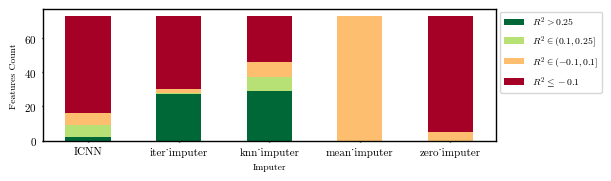

In [45]:
ax = r_bins.plot(y=R_classes, kind="bar", rot=0, stacked=True, colormap='RdYlGn_r', ylabel='Features Count')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in, fig_height_in)
ax.get_figure().savefig("r2_bins.pdf")